In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cclib
import pandas as pd

In [17]:
# -------------------------
# Functions
# -------------------------
def extract_tddft_data_for_files(directory, files):
    """Extract TD-DFT energies and oscillator strengths from Gaussian log files."""
    tddft_data = {}
    for log_file in files:
        file_path = os.path.join(directory, log_file)
        try:
            data = cclib.io.ccread(file_path)
            if hasattr(data, 'etenergies') and hasattr(data, 'etoscs'):
                # Convert from wavenumbers to eV using the factor 0.000123984
                converted_energies = [energy * 0.000123984 for energy in data.etenergies]
                oscillation_strengths = data.etoscs
                tddft_data[log_file] = (converted_energies, oscillation_strengths)
            else:
                print(f"No excited state data found in {log_file}.")
        except Exception as e:
            print(f"Error reading {log_file}: {e}")
    return tddft_data

def spectrum(E, osc, sigma, x):
    """Generate a Gaussian-broadened spectrum from energies E and oscillator strengths osc."""
    gE = []
    for Ei in x:
        total = 0
        for Ej, o in zip(E, osc):
            total += o * np.exp(-(((Ej - Ei) / sigma) ** 2))
        gE.append(total)
    return gE

def min_max_normalize(values):
    """
    Rescale an array to the [0,1] range using min–max normalization:
    y_norm = (y - y.min()) / (y.max() - y.min())
    """
    arr = np.asarray(values, dtype=float)
    arr_min = arr.min()
    arr_max = arr.max()
    # Handle the edge case where all values might be identical
    if np.isclose(arr_min, arr_max):
        return np.zeros_like(arr)  # or arr (any constant)
    return (arr - arr_min) / (arr_max - arr_min)

def convert_nm_to_ev(wavelength):
    """Convert a wavelength in nm to energy in eV."""
    h = 6.62606876e-34   # Planck's constant in J·s
    c = 299792458        # Speed of light in m/s
    eV_conversion = 1.6022e-19  # Joules per eV
    return (h * c) / (wavelength * 1e-9) / eV_conversion


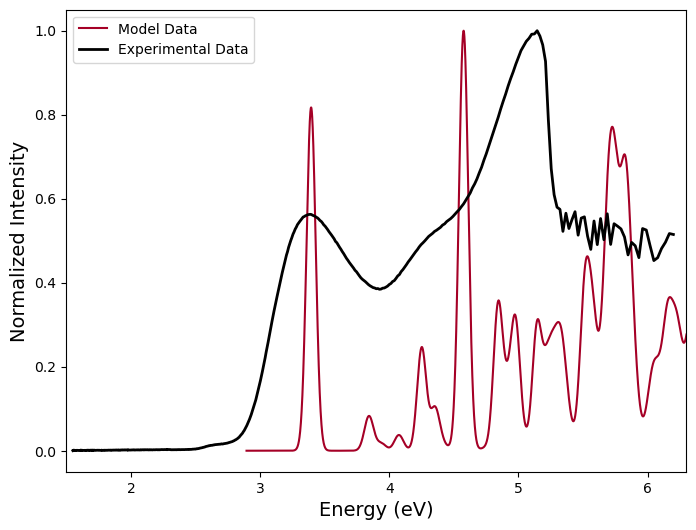

Plot saved to /Users/jennadraude/desktop/spectrum_plot.png


In [20]:
# -------------------------
# Main Script
# -------------------------
if __name__ == '__main__':
    # --- Theoretical Data ---
    theo_directory = "/Users/jennadraude/desktop/run__37.95233354_"
    files = ['gaussian_test.log']
    
    # Extract theoretical TD-DFT data
    extracted_data = extract_tddft_data_for_files(theo_directory, files)
    
    # --- Experimental Data ---
    exp_directory = "/Users/jennadraude/desktop/"
    exp_file = os.path.join(exp_directory, 'AG-203-cis.txt')
    
    # Load experimental data
    exp_data = pd.read_csv(exp_file, delim_whitespace=True, header=None, skiprows=1, names=['energies', 'intensities'])
    exp_data['energies'] = pd.to_numeric(exp_data['energies'], errors='coerce')
    exp_data['intensities'] = pd.to_numeric(exp_data['intensities'], errors='coerce')
    exp_data = exp_data.dropna()

    # Sort by ascending energies (optional but recommended)
    exp_data = exp_data.sort_values(by='energies')

    # 1) Normalize experimental intensities to [0,1]
    exp_data['intensities'] = min_max_normalize(exp_data['intensities'])
    
    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot theoretical model data (normalized to [0,1] after computing the raw spectrum)
    if extracted_data:
        # Just pick one color for model, e.g., red
        color_model = '#a50026'
        # If you have multiple logs, each gets a separate line
        for idx, (file_name, (energies, osc_strengths)) in enumerate(extracted_data.items()):
            # Create a finely spaced x-axis based on the theoretical energies
            x = np.linspace(min(energies) - 0.5, max(energies) + 0.5, num=10000)
            gE_raw = spectrum(energies, osc_strengths, sigma=0.05, x=x)
            
            # 2) Normalize model data to [0,1]
            gE_raw = min_max_normalize(gE_raw)
            
            label_model = 'Model Data' if idx == 0 else None  # Label once
            ax.plot(x, gE_raw, color=color_model, label=label_model)
    
    # Plot experimental data in black
    ax.plot(
        exp_data['energies'],
        exp_data['intensities'],
        color='black',
        linewidth=2,
        label='Experimental Data',
        zorder=10
    )
    
    # Option 1: Hard-coded eV range
    ax.set_xlim(1.5, 6.3)
    
    # Option 2: If you prefer using nm -> eV conversion
    # ax.set_xlim(convert_nm_to_ev(800), convert_nm_to_ev(200))
    
    ax.set_ylabel("Normalized Intensity", fontsize=14)
    ax.set_xlabel("Energy (eV)", fontsize=14)
    ax.legend(fontsize=10)
    
    # Save and show
    save_path = "/Users/jennadraude/desktop/spectrum_plot.png"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {save_path}")